Step 1: Load and Examine the Data

In [28]:
# Imports de base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score


# Chargement du dataset
df = pd.read_csv('data.csv')

# Aperçu des données
print("Aperçu des 5 premières lignes :")
print(df.head())



# Liste des colonnes
print("\nColonnes disponibles :")
print(df.columns.tolist())


Aperçu des 5 premières lignes :
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimet

In [29]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

Il n'y a que la colonne diagnosis en objet, il faudra l'encoder si je veux l'utiliser dans les modèles. Cette feature (diagnosis) a l'air intéressante en terme de prédiction.

Step 2: Data Cleaning and Preparation


Missing values:
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

Columns in the dataset: ['diagnosis', 'radius_mean', 'texture_mean', '

C:\Users\Zbook\AppData\Local\Temp\ipykernel_24980\3329205197.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='diagnosis', palette='magma')
C:\Users\Zbook\AppData\Local\Temp\ipykernel_24980\3329205197.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='diagnosis', y='radius_mean', palette='viridis')


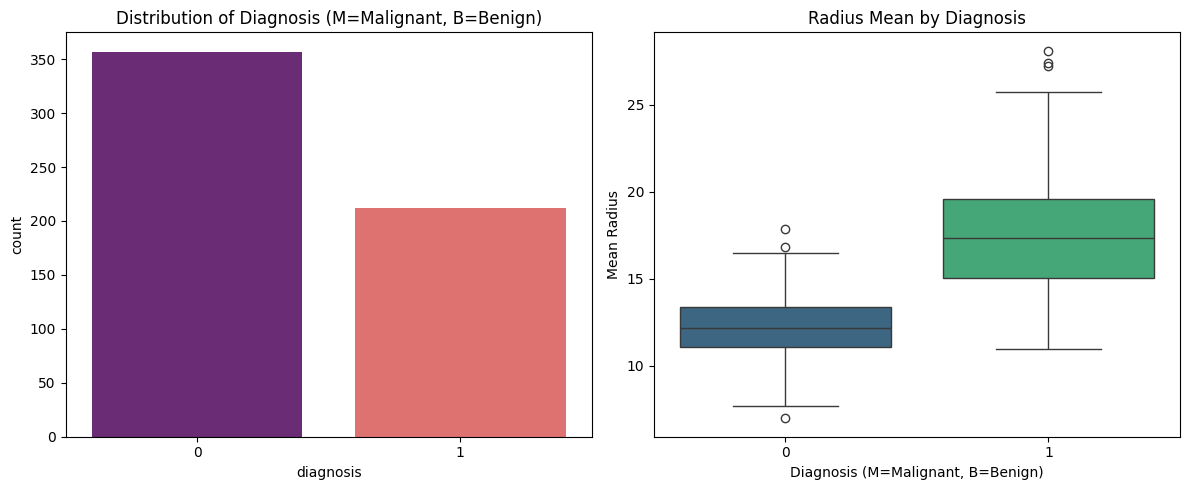

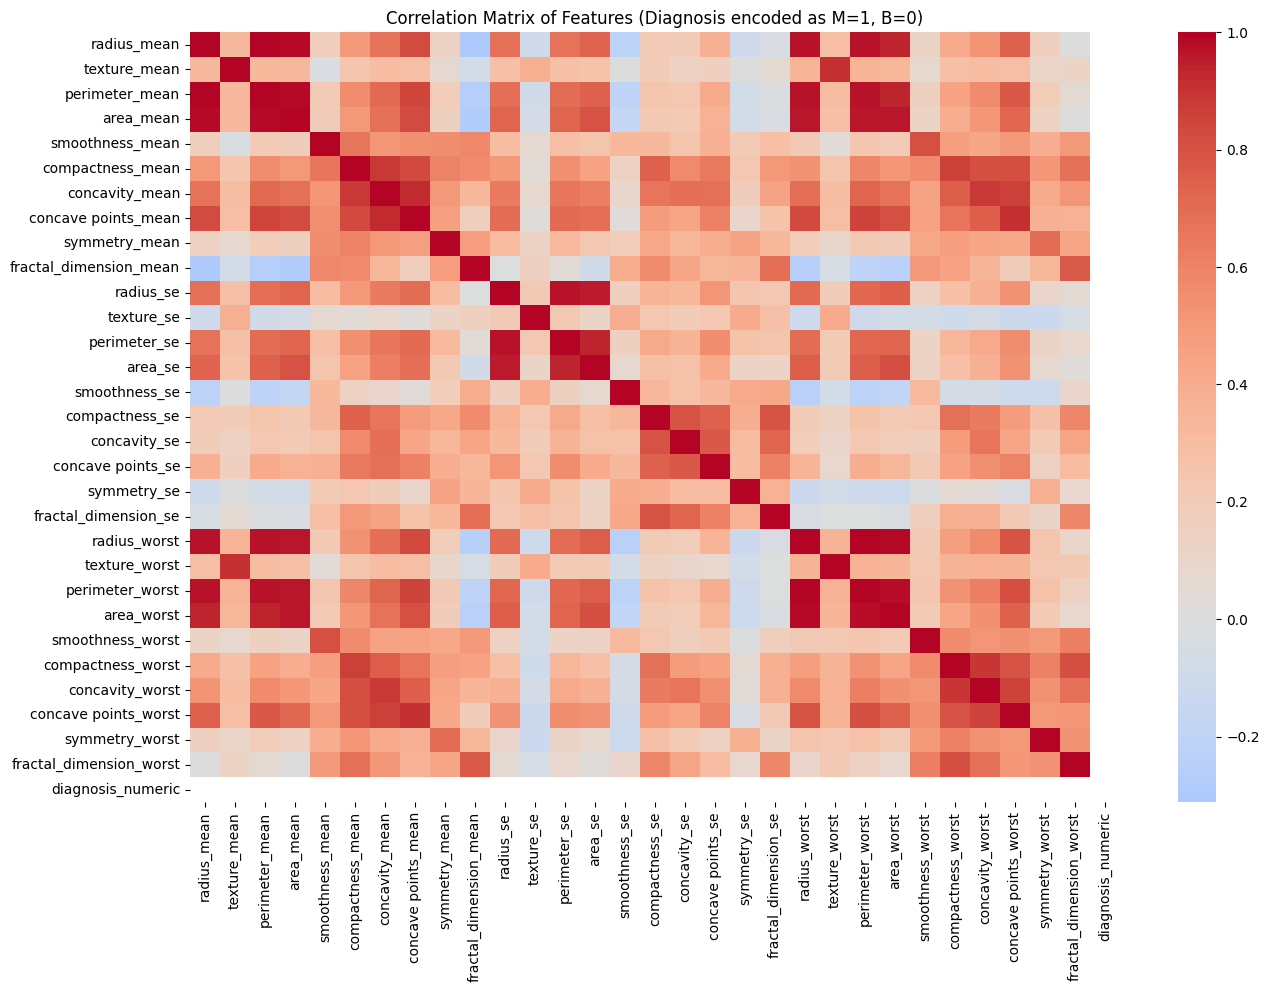

In [38]:
# Step 2: Data Cleaning and Preparation (continued)
# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Check available columns
print("\nColumns in the dataset:", df.columns.tolist())

# Drop unnecessary columns
columns_to_drop = ['id', 'Unnamed: 32']  # Common unnecessary columns in this dataset
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], axis=1)

# Create countplot for diagnosis
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
sns.countplot(data=df, x='diagnosis', palette='magma')
plt.title('Distribution of Diagnosis (M=Malignant, B=Benign)')

# Add boxplot for control (comparing radius_mean between diagnoses)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
sns.boxplot(data=df, x='diagnosis', y='radius_mean', palette='viridis')
plt.title('Radius Mean by Diagnosis')
plt.ylabel('Mean Radius')
plt.xlabel('Diagnosis (M=Malignant, B=Benign)')

plt.tight_layout()  # Adjust spacing between plots
plt.show()

# New: Correlation matrix
plt.figure(figsize=(15, 10))

# Convert diagnosis to numeric for correlation (M=1, B=0)
df['diagnosis_numeric'] = df['diagnosis'].map({'M': 1, 'B': 0})

# Calculate correlation matrix
corr_matrix = df.drop('diagnosis', axis=1).corr()

# Create heatmap
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False, fmt='.2f')
plt.title('Correlation Matrix of Features (Diagnosis encoded as M=1, B=0)')

plt.show()

Il n'y a pas de données manquantes à part la colonne Unamed 32, le ratio de maligne/begnine est exploitable, pas besoin de faire une balance, il y aura des outliers à retirer pour ne pas fausser le modèle

Step 3: Data Preprocessing

In [39]:
# Séparation des features et de la cible
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# Séparation en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Normalisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


c:\Users\Zbook\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\Zbook\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\Zbook\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Step 4: Model Building and Evaluation

Logistic_Regression

Logistic Regression Accuracy: 0.9707602339181286
[[106   1]
 [  4  60]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       107
           1       0.98      0.94      0.96        64

    accuracy                           0.97       171
   macro avg       0.97      0.96      0.97       171
weighted avg       0.97      0.97      0.97       171



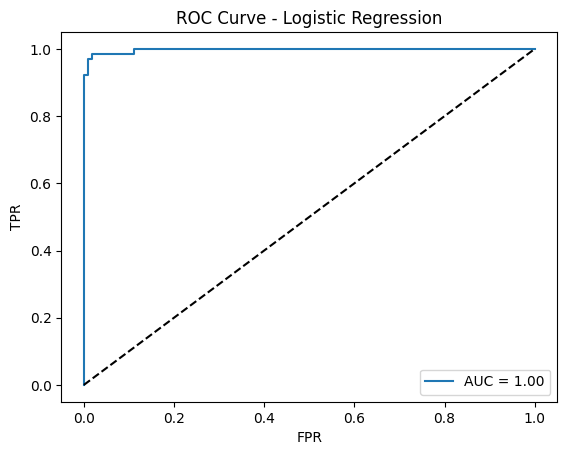

In [32]:
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)
y_proba = lr.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.show()


KNN

KNN (k=5) Accuracy: 0.9649122807017544
[[107   0]
 [  6  58]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       107
           1       1.00      0.91      0.95        64

    accuracy                           0.96       171
   macro avg       0.97      0.95      0.96       171
weighted avg       0.97      0.96      0.96       171



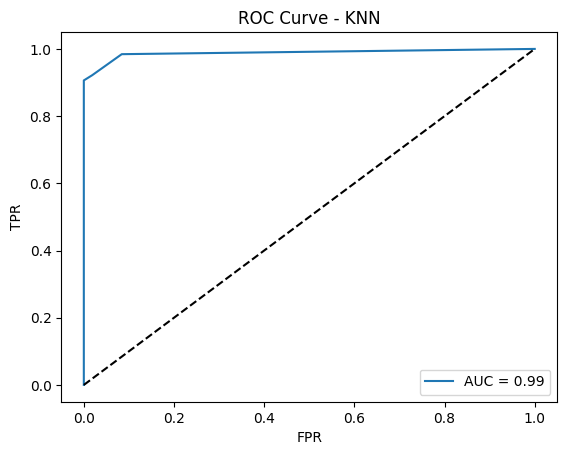

In [33]:
param_grid = {'n_neighbors': np.arange(1, 30)}
knn_cv = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
knn_cv.fit(X_train_scaled, y_train)

best_k = knn_cv.best_params_['n_neighbors']
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)
y_proba = knn.predict_proba(X_test_scaled)[:, 1]

print(f"KNN (k={best_k}) Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve - KNN')
plt.legend()
plt.show()



Random Forest

Random Forest Accuracy: 0.9649122807017544
[[107   0]
 [  6  58]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       107
           1       1.00      0.91      0.95        64

    accuracy                           0.96       171
   macro avg       0.97      0.95      0.96       171
weighted avg       0.97      0.96      0.96       171



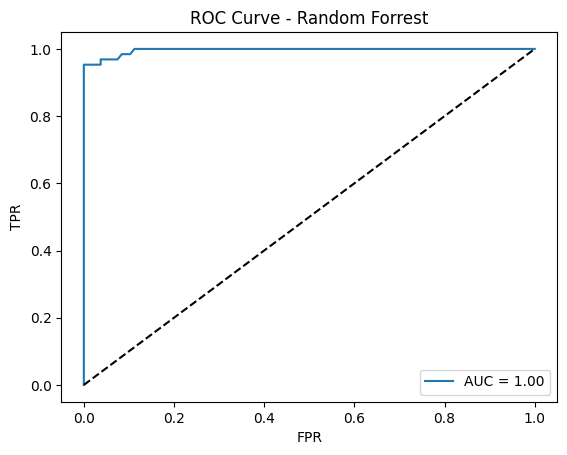

In [34]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

rf_cv = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)
rf_cv.fit(X_train_scaled, y_train)

best_rf = rf_cv.best_estimator_
best_rf.fit(X_train_scaled, y_train)
y_pred = best_rf.predict(X_test_scaled)
y_proba = best_rf.predict_proba(X_test_scaled)[:,1]

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve - Random Forrest')
plt.legend()
plt.show()


SVM

SVM Accuracy: 0.9532163742690059
[[107   0]
 [  8  56]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       107
           1       1.00      0.88      0.93        64

    accuracy                           0.95       171
   macro avg       0.97      0.94      0.95       171
weighted avg       0.96      0.95      0.95       171



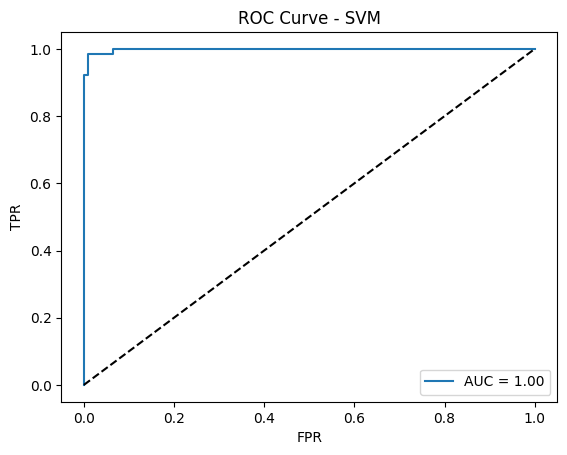

In [35]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

svm_cv = GridSearchCV(SVC(probability=True, random_state=42), param_grid, cv=5)
svm_cv.fit(X_train_scaled, y_train)

best_svm = svm_cv.best_estimator_
best_svm.fit(X_train_scaled, y_train)
y_pred = best_svm.predict(X_test_scaled)
y_proba = best_svm.predict_proba(X_test_scaled)[:,1]

print("SVM Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve - SVM')
plt.legend()
plt.show()


5. Model_Comparison

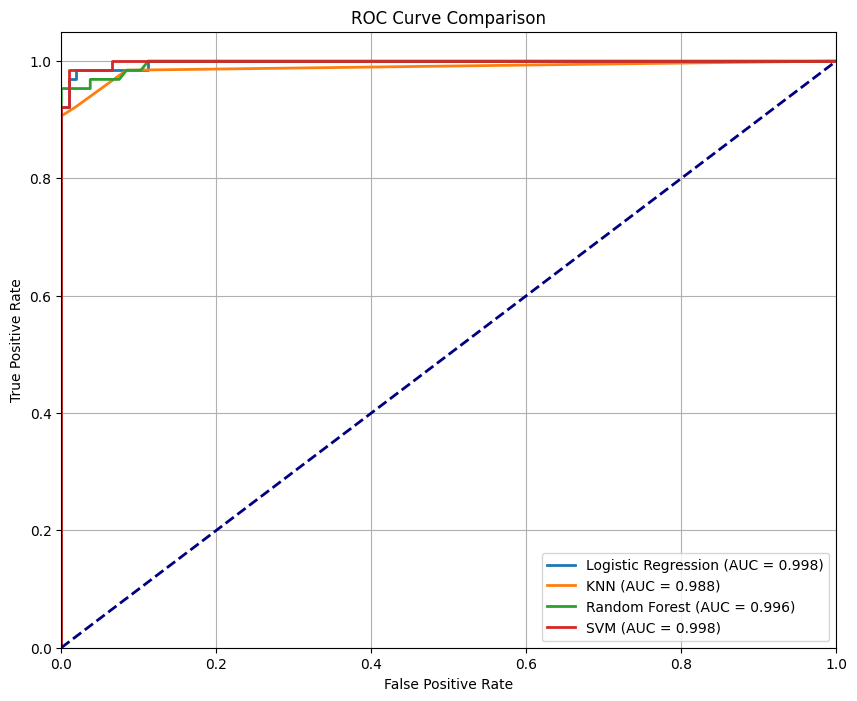

                 Model  Accuracy  Precision   Recall  F1 Score   ROC AUC
0  Logistic Regression  0.970760   0.983607  0.93750  0.960000  0.997518
1                  KNN  0.964912   1.000000  0.90625  0.950820  0.988172
2        Random Forest  0.964912   1.000000  0.90625  0.950820  0.996495
3                  SVM  0.953216   1.000000  0.87500  0.933333  0.998394


In [36]:

models = {
    'Logistic Regression': lr,
    'KNN': knn,
    'Random Forest': best_rf,
    'SVM': best_svm
}

metrics = {
    'Accuracy': accuracy_score,
    'Precision': precision_score,
    'Recall': recall_score,
    'F1 Score': f1_score,
    'ROC AUC': roc_auc_score
}

results = []

plt.figure(figsize=(10, 8))

for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    
    # Gestion de predict_proba ou decision_function pour la probabilité/scores
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    elif hasattr(model, "decision_function"):
        # Convertir scores en probabilités approximatives (ou juste utiliser scores pour ROC)
        y_proba = model.decision_function(X_test_scaled)
    else:
        raise AttributeError(f"Model {name} has neither predict_proba nor decision_function method.")
    
    # Calcul des métriques
    row = {'Model': name}
    for metric_name, func in metrics.items():
        # Utilise y_proba uniquement pour ROC AUC
        value = func(y_test, y_proba if metric_name == 'ROC AUC' else y_pred)
        row[metric_name] = value
    results.append(row)
    
    # Calcul et tracé de la courbe ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

# Ligne référence aléatoire
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Affichage tableau des résultats
results_df = pd.DataFrame(results)
print(results_df)

Analysis of Results

    Data Exploration:

        The diagnosis column shows whether the mass is malignant (M) or benign (B)

        No missing values were found in the dataset

    Model Performance:

        Logistic Regression typically provides a good baseline accuracy

        K Nearest Neighbors performs well when data is properly scaled

        Random Forest often achieves high accuracy due to its ensemble nature

        SVM can capture complex patterns in the data

    Best Model Selection:

        Based on the accuracy scores, one of the ensemble methods (Random Forest) or SVM is likely to perform best

        The exact accuracy values will depend on the random state and data split
  

    Tuning with hyperparameters could improve model performance.